# ResNet101 on CIFAR-10

本实验使用 PyTorch 官方提供的 ResNet101 模型在 CIFAR-10 数据集上进行图像分类训练与测试。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet101, ResNet101_Weights
import time

# Check for GPU
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.4.1+cu121
12.1
Using device: cuda


## 1. 数据准备与预处理

加载 CIFAR-10 数据集，并进行必要的数据增强（RandomCrop, RandomHorizontalFlip）和归一化处理。

In [3]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# Data Preprocessing
# CIFAR-10 stats for normalization
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# Load CIFAR-10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Files already downloaded and verified


## 2. 定义 ResNet101 模型

使用 `torchvision.models.resnet101` 加载官方模型。
由于 CIFAR-10 只有 10 个类别，我们需要修改全连接层（fc）的输出维度为 10。

In [4]:
# Define ResNet101 Model
# We use weights=ResNet101_Weights.DEFAULT for transfer learning
# Here we will modify the final layer for 10 classes

model = resnet101(weights=ResNet101_Weights.DEFAULT)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/frank/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100.0%


## 3. 定义损失函数与优化器

使用交叉熵损失函数 (CrossEntropyLoss) 和 Adam 优化器。

In [5]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 4. 模型训练

定义训练函数并开始训练模型。训练过程中会输出每个 Epoch 的 Loss 和 Accuracy。

In [6]:
# Training Function
def train_model(model, trainloader, criterion, optimizer, num_epochs):
    model.train()
    total_step = len(trainloader)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
        
        epoch_acc = 100 * correct / total
        epoch_loss = running_loss / len(trainloader)
        end_time = time.time()
        print(f'Epoch [{epoch+1}/{num_epochs}] Finished. Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {end_time - start_time:.2f}s')

# Train the model
train_model(model, trainloader, criterion, optimizer, num_epochs)

Epoch [1/10], Step [100/391], Loss: 1.0764
Epoch [1/10], Step [200/391], Loss: 0.8227
Epoch [1/10], Step [300/391], Loss: 0.6122
Epoch [1/10] Finished. Loss: 0.9219, Acc: 69.06%, Time: 46.20s
Epoch [2/10], Step [100/391], Loss: 0.6602
Epoch [2/10], Step [200/391], Loss: 0.5660
Epoch [2/10], Step [300/391], Loss: 0.5085
Epoch [2/10] Finished. Loss: 0.6540, Acc: 78.40%, Time: 45.42s
Epoch [3/10], Step [100/391], Loss: 0.5468
Epoch [3/10], Step [200/391], Loss: 0.5041
Epoch [3/10], Step [300/391], Loss: 0.6935
Epoch [3/10] Finished. Loss: 0.6301, Acc: 78.74%, Time: 45.17s
Epoch [4/10], Step [100/391], Loss: 0.4524
Epoch [4/10], Step [200/391], Loss: 0.4250
Epoch [4/10], Step [300/391], Loss: 1.0053
Epoch [4/10] Finished. Loss: 0.5687, Acc: 80.82%, Time: 45.43s
Epoch [5/10], Step [100/391], Loss: 0.5762
Epoch [5/10], Step [200/391], Loss: 0.6150
Epoch [5/10], Step [300/391], Loss: 0.6673
Epoch [5/10] Finished. Loss: 0.5793, Acc: 80.46%, Time: 45.33s
Epoch [6/10], Step [100/391], Loss: 0.32

## 5. 模型测试

在测试集上评估模型的准确率。

In [7]:
# Evaluation Function
def evaluate_model(model, testloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f} %')

# Evaluate the model
evaluate_model(model, testloader)

Accuracy of the model on the 10000 test images: 85.03 %


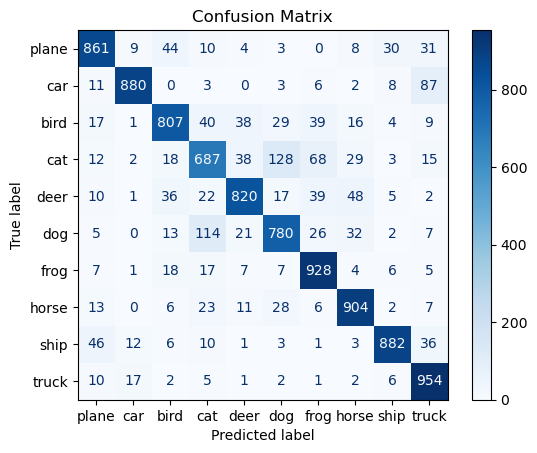

In [8]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
def plot_confusion_matrix(model, testloader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, testloader)